# Calculating ground states on large scale systems: Quantum Krylov Subspaces

## Step 1: Map problem to quantum native format

Across disciplines, we're interested in learning ground state properties of quantum systems. Examples include understanding the fundamental nature of particles and forces, predicting and undestanding the behavior of complex materials and understanding bio-chemical interactions and reactions. Because of the exponential growth of the Hilbert space and the correlation that arise in entangled systems, classical algorithm struggle to solve this problem for quantum systems of increasing size. At one end of the spectrum, existing approach that take advantage of the quantum hardware focus on variational quantum methods (e. g. [variational quantum eigen-solver](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)). These techniques face challenges with current devices because of the high number of function calls required in the optimization process, which is incompatible with advanced error mitigation techniques, thus limiting their efficacy to small systems. At the other end of the spectrum, there are fault-tolerant quantum methods with performance guarantees (e.g. [quantum phase estimation](https://arxiv.org/pdf/quant-ph/0604193.pdf)) which require deep circuits that can be executed only on a fault-tolerant device. For these reasons, we introduce here a quantum algorithm based on subspace methods (as reviewed [here](https://arxiv.org/pdf/2312.00178.pdf)), the quantum Krylov algorithm. This algorithm performs well at large scale on existing quantum hardware, shares similar [performance guarantees](https://arxiv.org/pdf/2110.07492.pdf) as phase estimation, are compatible with advanced error mitigation techniques and could provide results that are classically inaccessible.

Let us now go into more details of how subspace methods, and the quantum Krylov algorithm in particular, work. Given a matrix $H$ for which we want to know its lowest eigenvalue, subspace methods construct of a smaller representation $\tilde{H}$ of $H$, which captures its properties of interest. In the case of the quantum Krylov algorithm, the Krylov subspace is used to construct the effective representation.

### What is the Krylov subspace? 

By definition, the Krylov subspace $K^r$ of order $r$ is the subspace spanned by vectors obtained by multiplying higher powers of $H$, up to $r-1$, with a reference vector $\vert \psi \rangle$.

$$K^r = \left\{ \vert \psi \rangle, H \vert \psi \rangle, H^2 \vert \psi \rangle, ..., H^{r-1} \vert \psi \rangle \right\}$$

We can gain some insight on why this subspace is interesting by expanding the reference state in terms of the eigenvectors $\vert \lambda_i \rangle$ of the matrix $H$:

$$ \vert \psi \rangle = c_1 \vert \lambda_1 \rangle + c_2 \vert \lambda_2 \rangle + ... + c_n \vert \lambda_n \rangle $$

Applying $j^{th}$ power of the matrix $H$ gives:

$$ H^n \vert \psi \rangle = c_1 \lambda_1^n \vert \lambda_1 \rangle + c_2 \lambda_2^n \vert \lambda_2 \rangle + ... + c_n \lambda_n^n \vert \lambda_n \rangle $$

Which means that the component $k$ with the largest eigenvalue $\lambda_k$ is amplified by the power iteration (This can also be a problem as the basis vector become too similar to each other). The same is true for the smallest eigenvalue, if we consider power iteration of the matrix $H^{-1}$.

### Why is it useful for ground state energy problems?

The Krylov subspace is constructed using the power iteration method. Therefore, states in the Krylov subspace corresponding to the multiplication with higher power of the matrix with the reference states will have the contribution of the ground state $\vert \lambda_k \rangle$ enhanced.


The Krylov subspace that we use classically cannot be accessed on a quantum computer as $H$ is not a unitary matrix. Instead, we can use the time-evolution operator $U = e^{-iHt}$ which can be shown to give similar [convergence guarantees](https://arxiv.org/pdf/2110.07492.pdf) as the power method. Powers of $U$ then become different time steps $U^k = e^{-iH(kt)}$.


$$K_U^r = \left\{ \vert \psi \rangle, U \vert \psi \rangle, U^2 \vert \psi \rangle, ..., U^{r-1} \vert \psi \rangle \right\}$$

The subspace $K_U^r$ obtained in this way is called "Unitary" Krylov subspace.


### How does the algorithm work in summary?

First, we want to find a compact represention of the Hamiltonian in the Krylov subspace $\tilde{H}$. Given that the Krylov subspace has dimension $r$, the Hamiltonian projected into the Krylov subspace will have dimensions $r \times r$. We can then easily diagonalize the projected Hamiltonian $\tilde{H}$. However, we cannot directly diagonalize $\tilde{H}$ because of the non-orthogonality of the Krylov subpace vectors. We'll have to measure their overlaps and construct a matrix $\tilde{S}$ collecting them to do so. We can then  solve the generalized eigenvalue problem

$$ \tilde{H} \ \vec{c} = c \ \tilde{S} \ \vec{c} $$

Where $\tilde{H}=\langle \psi_m \vert H \vert \psi_n \rangle$ is the Hamiltonian matrix in the Krylov subspace $K_D = \left\{ \vert \psi_0 \rangle, \vert \psi_1 \rangle, ..., \vert \psi_D \rangle \right\}$ with dimension $D$, $\vec{c}$ is a vector of variational coefficients that are optimized to get the lowest value of the energy $c_{min}=E_{GS}$ and $\tilde{S}=\langle \psi_m  \vert \psi_n \rangle$ is a matrix of overlaps between states of the Krylov subspace.

Each of the Krylov subspace's vectors are obtained by time-evolving the reference state $\vert \psi \rangle$ under the Hamiltonian $H$ for a certain time: $\vert \psi_l \rangle = U \vert \psi \rangle = e^{-i H t_l}\vert \psi \rangle$. 

We can implement the algorithm on a quantum computer by using the Hadamard test to calculate the matrix elements of $\tilde{H}$ and $\tilde{S}$ as expectation values:

$$\langle \psi_m \vert H \vert \psi_n \rangle = $$
$$= \langle \psi \vert  e^{i H t_m}   H e^{-i H t_n} \vert \psi \rangle$$
$$= \langle \psi \vert  e^{i H m \delta t}   H e^{-i H n \delta t} \vert \psi \rangle$$
$$= \langle \psi \vert H e^{-i H (n-m) \delta t} \vert \psi \rangle$$

### Imports and definitions



In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from typing import Union, List
import warnings
warnings.filterwarnings('ignore')

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit.providers.fake_provider import Fake20QV1
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator


def solve_regularized_gen_eig(h: np.ndarray, s:np.ndarray, threshold: float, k: int =1, return_dimn: bool = False) -> Union[float, List[float]]:
    """
    Method for solving the generalized eigenvalue problem with regularization

    Args:
        h (numpy.ndarray):
            The effective representation of the matrix in the Krylov subspace
        s (numpy.ndarray):
            The matrix of overlaps between vectors of the Krylov subspace
        threshold (float):
            Cut-off value for the eigenvalue of s
        k (int):
            Number of eigenvalues to return
        return_dimn (bool):
            Whether to return the size of the regularized subspace

    Returns:
        lowest k-eigenvalue(s) that are the solution of the regularized generalized eigenvalue problem

    
    """
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array([vec for val, vec in zip(s_vals, s_vecs) if val > threshold])
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    if k==1:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][0], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][0]
    else:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k]

### Define Hamiltonian

Let's consider the Heisenberg Hamiltonian for $N$ qubits on a linear chain: $H= J \sum_{i,j}^N X_i X_j + Y_i Y_j + Z_i Z_j$

In [2]:
# Define problem Hamiltonian.
n_qubits = 5
J = 1 # coupling strength for ZZ interaction

# Define the Hamiltonian: 
H_int = [['I']*n_qubits for _ in range(3*(n_qubits-1))]
for i in range(n_qubits-1):
    H_int[i][i] = 'Z'
    H_int[i][i+1] = 'Z'
for i in range(n_qubits-1):
    H_int[n_qubits-1+i][i] = 'X'
    H_int[n_qubits-1+i][i+1] = 'X'
for i in range(n_qubits-1):
    H_int[2*(n_qubits-1)+i][i] = 'Y'
    H_int[2*(n_qubits-1)+i][i+1] = 'Y'
H_int = [''.join(term) for term in H_int]
H_tot = [(term, J) if term.count('Z') == 2 else (term, 1) for term in H_int]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
print(H_tot)

[('ZZIII', 1), ('IZZII', 1), ('IIZZI', 1), ('IIIZZ', 1), ('XXIII', 1), ('IXXII', 1), ('IIXXI', 1), ('IIIXX', 1), ('YYIII', 1), ('IYYII', 1), ('IIYYI', 1), ('IIIYY', 1)]


### Set parameters for the algorithm

In [3]:
# Set parameters for quantum Krylov algorithm
krylov_dim = 20 # size of krylov subspace
dt = 0.1 # time step
num_trotter_steps = 4
dt_circ = dt/num_trotter_steps

### State preparation
Pick a reference state $\vert \psi \rangle$ that has some overlap with the ground state. For this Hamiltonian, We use the "checkerboard" state $\vert 0101...01 \rangle$ as our reference.

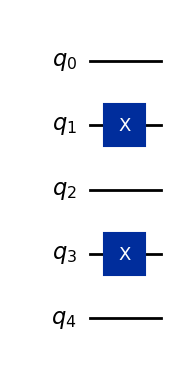

In [4]:
qc_state_prep = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    if i%2 != 0:
        qc_state_prep.x(i)
qc_state_prep.draw('mpl')

### Time evolution

We can realize the time-evolution operator generated by a given Hamiltonian: $U=e^{-iHt}$ via the [Suzuki-Trotter approximation]((https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.SuzukiTrotter)).

In [5]:
t = Parameter('t')

## Create the time-evo op circuit
evol_gate = PauliEvolutionGate(H_op, time=t, synthesis=SuzukiTrotter(order=num_trotter_steps) )

qr = QuantumRegister(n_qubits)
qc_evol = QuantumCircuit(qr)
qc_evol.append(evol_gate, qargs=qr)


### Hadamard test



\begin{equation}
    |0\rangle_a|\psi_0\rangle\quad\longrightarrow\quad\frac{1}{\sqrt{2}}\Big(|0\rangle+|1\rangle\Big)_a|\psi_0\rangle\quad\longrightarrow\quad\frac{1}{\sqrt{2}}\Big(|0\rangle_a|\psi_0\rangle+|1\rangle_aU_j^\dagger PU_k|\psi_0\rangle\Big)
\end{equation}
Where $P$ is one of the terms in the decomposition of the Hamiltonian $H=\sum P$. To measure $X$, first apply $H$...
\begin{equation}
    \longrightarrow\quad\frac{1}{2}|0\rangle_a\Big(|\psi_0\rangle+U_j^\dagger PU_k|\psi_0\rangle\Big) + \frac{1}{2}|1\rangle_a\Big(|\psi_0\rangle-U_j^\dagger PU_k|\psi_0\rangle\Big)
\end{equation}
... then measure:
\begin{equation}
\begin{split}
    \Rightarrow\quad\langle X\rangle_a &= \frac{1}{4}\Bigg(\Big\||\psi_0\rangle+U_j^\dagger PU_k|\psi_0\rangle\Big\|^2-\Big\||\psi_0\rangle-U_j^\dagger PU_k|\psi_0\rangle\Big\|^2\Bigg) \\
    &= \text{Re}\Big[\langle\psi_0|U_j^\dagger PU_k|\psi_0\rangle\Big].
\end{split}
\end{equation}
Similarly, measuring $Y$ yields
\begin{equation}
    \langle Y\rangle_a = \text{Im}\Big[\langle\psi_0|U_j^\dagger PU_k|\psi_0\rangle\Big].
\end{equation}

Circuit for calculating the real part of the overlap in S via Hadamard test


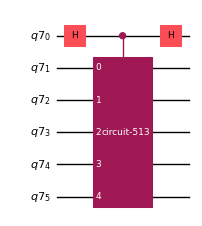

In [6]:
## Create the time-evo op circuit
evol_gate = PauliEvolutionGate(H_op, time=dt, synthesis= SuzukiTrotter(order=num_trotter_steps) ) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op

## Create the time-evo op dagger circuit
evol_gate_d = PauliEvolutionGate(H_op, time=dt, synthesis= SuzukiTrotter(order=num_trotter_steps) )
evol_gate_d = evol_gate_d.inverse()

# Put pieces together
qc_reg = QuantumRegister(n_qubits)
qc_temp = QuantumCircuit(qc_reg)
qc_temp.compose(qc_state_prep, inplace=True)
for _ in range(num_trotter_steps):
    qc_temp.append(evol_gate, qargs=qc_reg)
for _ in range(num_trotter_steps):
    qc_temp.append(evol_gate_d, qargs=qc_reg)
qc_temp.compose(qc_state_prep.inverse(), inplace=True)

# Create controlled version of the circuit
controlled_U = qc_temp.to_gate().control(1)

# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits+1)
qc_real = QuantumCircuit(qr)
qc_real.h(0)
qc_real.append(controlled_U, list(range(n_qubits+1)))
qc_real.h(0)

print('Circuit for calculating the real part of the overlap in S via Hadamard test')
qc_real.draw('mpl', fold=-1, scale=0.5)

The Hadamard test circuit can be a deep circuit once we transpile to native gates and topology of a device. For example the 5 qubits case considered here 

In [ ]:
circuit_trans_unopt = transpile(circuits=qc_real.decompose().decompose(), backend=Fake20QV1())

print('The circuit has 2Q gates depth: ', circuit_trans_unopt.depth(lambda x: x[0].num_qubits == 2))


## Step 2: Optimize circuits and operators

We can optimize the deep circuits for the Hadamard test that we have obtained by introducing some approximations and relying on some assumption about the model Hamiltonian. For example, consider the following circuit for the Hadamard test:


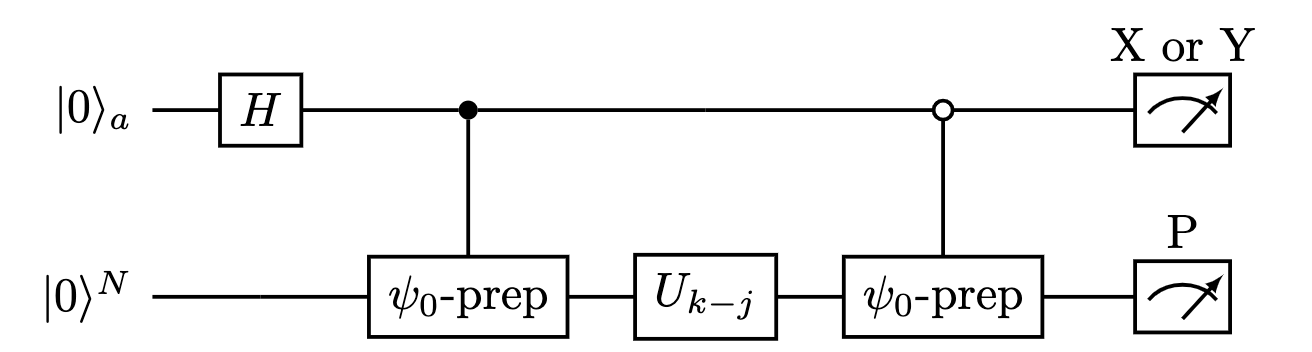

Assume we can classically calculate $E_0$, the eigenvalue of $|0\rangle^N$ under the Hamiltonian $H$.
This is satisfied when the Hamiltonian preserves the U(1) symmetry.
Assume that the gate $\psi_0-prep$ prepares our desired reference state $\ket{\psi_0}$, e.g., to prepare the HF state for chemistry $\psi_0-prep$ would be a product of single-qubit NOTs, so controlled-$\psi_0-prep$ is just a product of CNOTs.
Then the circuit above implements the following state prior to measurement:

\begin{equation}
\begin{split}
    \ket{0} \ket{0}^N\xrightarrow{H}&\frac{1}{\sqrt{2}}
    \left(
    \ket{0}\ket{0}^N+ \ket{1} \ket{0}^N
    \right)\\
    \xrightarrow{\text{1-ctrl-init}}&\frac{1}{\sqrt{2}}\left(|0\rangle|0\rangle^N+|1\rangle|\psi_0\rangle\right)\\
    \xrightarrow{U}&\frac{1}{\sqrt{2}}\left(e^{i\phi}\ket{0}\ket{0}^N+\ket{1} U\ket{\psi_0}\right)\\
    \xrightarrow{\text{0-ctrl-init}}&\frac{1}{\sqrt{2}}
    \left(
    e^{i\phi}\ket{0} \ket{\psi_0}
    +\ket{1} U\ket{\psi_0}
    \right)\\
    =&\frac{1}{2}
    \left(
    \ket{+}\left(e^{i\phi}\ket{\psi_0}+U\ket{\psi_0}\right)
    +\ket{-}\left(e^{i\phi}\ket{\psi_0}-U\ket{\psi_0}\right)
    \right)\\
    =&\frac{1}{2}
    \left(
    \ket{+i}\left(e^{i\phi}\ket{\psi_0}-iU\ket{\psi_0}\right)
    +\ket{-i}\left(e^{i\phi}\ket{\psi_0}+iU\ket{\psi_0}\right)
    \right)
\end{split}
\end{equation}

where we have used the classical simulable phase shift $ U\ket{0}^N = e^{i\phi}\ket{0}$ in the third line. Therefore the expectation values are obtained as

\begin{equation}
\begin{split}
    \langle X\otimes P\rangle&=\frac{1}{4}
    \Big(
    \left(e^{-i\phi}\bra{\psi_0}+\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}+U\ket{\psi_0}\right)
    \\
    &\qquad-\left(e^{-i\phi}\bra{\psi_0}-\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}-U\ket{\psi_0}\right)
    \Big)\\
    &=\text{Re}\left[e^{-i\phi}\bra{\psi_0}PU\ket{\psi_0}\right],
\end{split}
\end{equation}

\begin{equation}
\begin{split}
    \langle Y\otimes P\rangle&=\frac{1}{4}
    \Big(
    \left(e^{-i\phi}\bra{\psi_0}+i\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}-iU\ket{\psi_0}\right)
    \\
    &\qquad-\left(e^{-i\phi}\bra{\psi_0}-i\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}+iU\ket{\psi_0}\right)
    \Big)\\
    &=\text{Im}\left[e^{-i\phi}\bra{\psi_0}PU\ket{\psi_0}\right].
\end{split}
\end{equation}


### Decompose time-evolution operator with Suzuki-Trotter decomposition
Instead of implementing the time-evolution operator exactly we can use the Suzuki-Trotter decomposition to implement an approximation of it. Repeating several times a certain order Trotter decomposition gives us further reduction of the error introduced from the approximation. In the following, we directly build the Trotter implementation in the most efficient way for the interaction graph of the Hamiltonian we are considering (nearest neighbor interactions only). In practice we insert Pauli rotations $R_{xx}$, $R_{yy}$, $R_{zz}$ with a parametrized angle $t$ which correspond to the approximate implementation of $e^{-i (XX + YY + ZZ) t}$. This gives a much shallower circuit than what is obtained using the generic `PauliEvolutionGate()` functionality. 

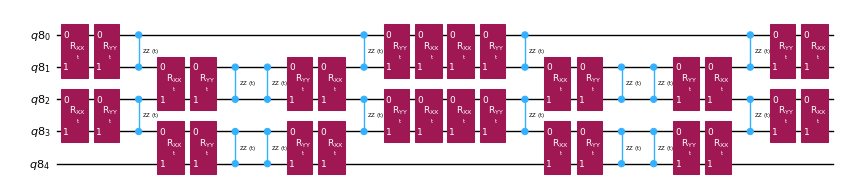

In [7]:
t = Parameter('t')

# Create instruction for rotation about XX+YY-ZZ:
Rxyz_circ = QuantumCircuit(2)
Rxyz_circ.rxx(t,0,1)
Rxyz_circ.ryy(t,0,1)
Rxyz_circ.rzz(t,0,1)
Rxyz_instr = Rxyz_circ.to_instruction(label='RXX+YY+ZZ')

interaction_list = [[[i, i+1] for i in range(0, n_qubits-1, 2)], [[i, i+1] for i in range(1, n_qubits-1, 2)]] # linear chain

qr = QuantumRegister(n_qubits)
trotter_step_circ = QuantumCircuit(qr)
for i, color in enumerate(interaction_list):
    for interaction in color:
        trotter_step_circ.append(Rxyz_instr, interaction)
reverse_trotter_step_circ = trotter_step_circ.reverse_ops()

qc_evol = QuantumCircuit(qr)
for step in range(num_trotter_steps):
    if step % 2 == 0:
        qc_evol = qc_evol.compose(trotter_step_circ)
    else:
        qc_evol = qc_evol.compose(reverse_trotter_step_circ)

qc_evol.decompose().draw('mpl', fold=-1, scale = 0.5)



### Use an optimized circuit for state preparation

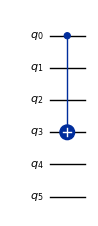

In [8]:
controlled_state_prep = QuantumCircuit(n_qubits + 1)
controlled_state_prep.cx(0,int(n_qubits/2)+1)
controlled_state_prep.draw('mpl', fold=-1, scale=0.5)


controlled_state_prep.draw('mpl', fold=-1, scale=0.5)

### Template circuits for calculating matrix elements of $\tilde{S}$ and $\tilde{H}$ via Hadamard test
The only difference between the circuits used in the Hadamard test will be the phase in the time-evolution operator and the observables measured. Therefore we can prepare a template circuit which represent the generic circuit for the Hadamard test, with placeholders for the gates that depend on the time-evolution operator.

In [9]:
# Parameters for the template circuits
parameters = []
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):
        parameters.append(dt_circ*(idx_ket-idx_bra))

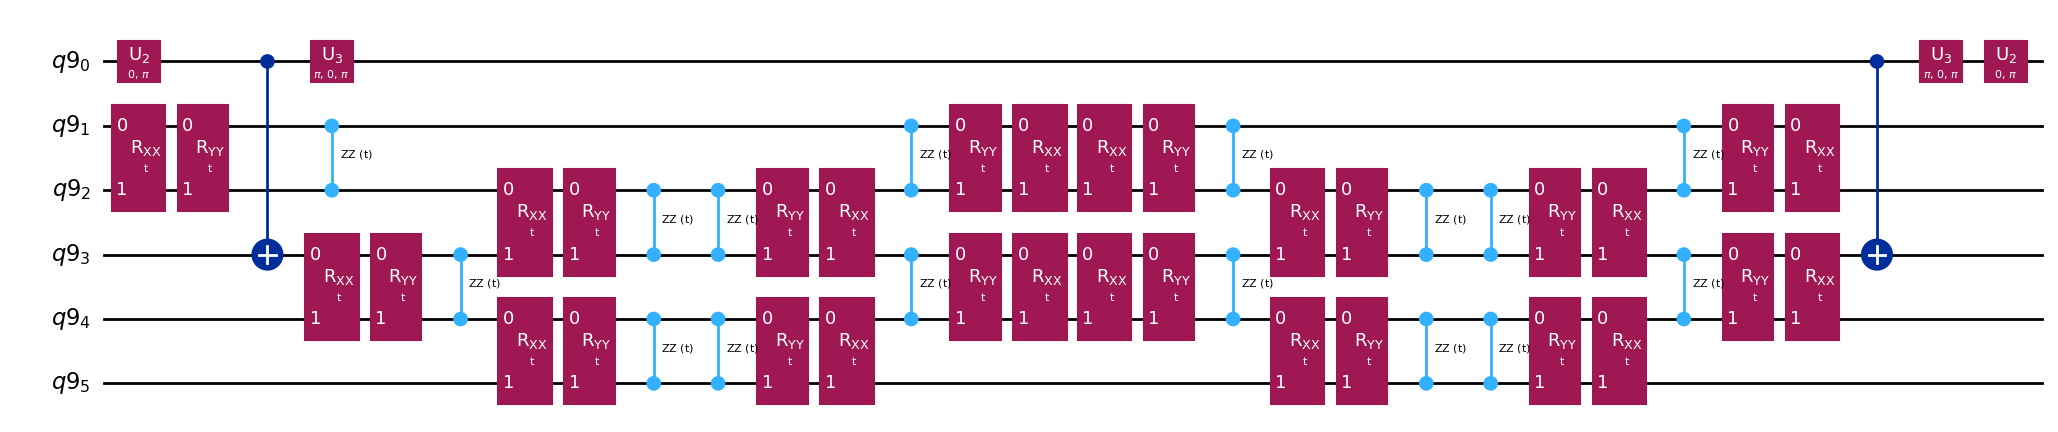

In [10]:
# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits+1)
qc_real = QuantumCircuit(qr)
qc_real.h(0)
qc_real.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
# qc_real.barrier()
qc_real.compose(qc_evol, list(range(1, n_qubits+1)), inplace=True)
# qc_real.barrier()
qc_real.x(0)
qc_real.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_real.x(0)
qc_real.h(0)

S_real_circ = qc_real.decompose().copy()

H_real_circ = qc_real.decompose().copy()

# # Create hadamard test circuit for imaginary part
qr = QuantumRegister(n_qubits+1)
qc_imag = QuantumCircuit(qr)
qc_imag.h(0)
qc_imag.sdg(0)
qc_imag.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
# qc_imag.barrier()
qc_imag.compose(qc_evol, list(range(1, n_qubits+1)), inplace=True)
# qc_imag.barrier()
qc_imag.x(0)
qc_imag.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_imag.x(0)
qc_imag.h(0)


S_imag_circ = qc_imag.decompose().copy()

H_imag_circ = qc_imag.decompose().copy()

S_real_circ.draw('mpl', fold=-1)

In [9]:
circuit_trans_opt = transpile(S_real_circ.decompose().decompose(), Fake20QV1())

print('The optimized circuit has 2Q gates depth: ', circuit_trans_opt.depth(lambda x: x[0].num_qubits ==2))
print('Compared to the unoptimized circuit depth of', circuit_trans_unopt.depth(lambda x: x[0].num_qubits == 2))

The optimized circuit has 2Q gates depth:  44


NameError: name 'circuit_trans_unopt' is not defined

We have considerably reduced the depth of the Hadamard test with a combination of Trotter approximation and uncontrolled unitaries

## Step 3: Execute using a quantum primitive

Instantiate the backend and set runtime parameters

In [24]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeGuadalupeV2
from qiskit_aer import AerSimulator


SIM = False
NOISE = False
service = QiskitRuntimeService(instance='quantum-demonstrations/main/krylov-gs')

if SIM:
    # backend = service.least_busy(simulator=True)
    
    if NOISE:
        backend = AerSimulator.from_backend(FakeGuadalupeV2(), seed_simulator=42)

    else:
        backend = AerSimulator()

else:
    backend_id = 'ibm_kyiv'
    backend = service.backend(backend_id)

shots = 10000


### Transpile + schedule with DD

In [25]:
from qiskit.circuit.library import XGate, YGate, RZGate
from qiskit.transpiler import InstructionProperties
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

if not SIM:

    X = XGate()
    Y = YGate()
    
    # dd_sequence = [X, X, X, X]

    dd_sequence=[XGate(), RZGate(np.pi), XGate(), RZGate(-np.pi)]
    spacing = [1 / 4, 1 / 2, 0, 0, 1 / 4]

    target = backend.target
    basis_gates = list(target.operation_names)
    
    y_gate_properties = {}
    for qubit in range(target.num_qubits):
        y_gate_properties.update(
            {
                (qubit,): InstructionProperties(
                    duration=target["x"][(qubit,)].duration,
                    error=target["x"][(qubit,)].error,
                )
            }
        )
    if 'y' not in target.operation_names:
        target.add_instruction(YGate(), y_gate_properties)

    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, basis_gates=basis_gates)


    pm.scheduling = PassManager(
        [
            ALAPScheduleAnalysis(target=target),
            PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence, spacing=spacing),
        ]
    )

    S_real_circ_trans = pm.run(S_real_circ)
    S_imag_circ_trans = pm.run(S_imag_circ)

    H_real_circ_trans = pm.run(H_real_circ)
    H_imag_circ_trans = pm.run(H_imag_circ)

elif SIM and NOISE:
    target = backend.target
    basis_gates = list(target.operation_names)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, basis_gates=basis_gates)

    S_real_circ_trans = pm.run(S_real_circ)
    S_imag_circ_trans = pm.run(S_imag_circ)

    H_real_circ_trans = pm.run(H_real_circ)
    H_imag_circ_trans = pm.run(H_imag_circ)


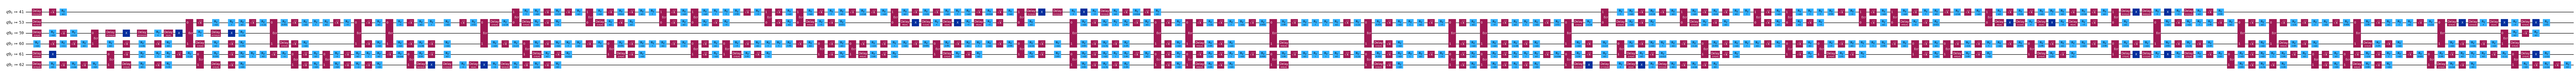

In [26]:
S_real_circ_trans.draw('mpl', fold=-1, idle_wires=False)

In [ ]:
# S_real_circ_trans_dd.depth(lambda x: x[0].num_qubits==True)

In [ ]:
# S_real_circ.decompose().decompose().draw('mpl', fold=-1, idle_wires=False)

In [ ]:
# S_real_circ.decompose().decompose().depth(lambda x: x[0].num_qubits==True)

In [ ]:
# from qiskit.visualization import timeline_drawer
# from qiskit.transpiler.passes.scheduling import ALAPSchedule
# from qiskit.transpiler import PassManager, InstructionDurations

# b_circ = S_real_circ_trans_dd.assign_parameters({t:1})
# durations = InstructionDurations().from_backend(backend)
# pm = PassManager([ALAPSchedule(durations=durations)])
# sched_circ = pm.run(b_circ)

# timeline_drawer(sched_circ, show_idle=False)
# # timeline_drawer(b_circ)

In [27]:
# Define observables to measure for S
observable = 'I'*(n_qubits) + 'Z'

if not SIM or (SIM and NOISE):

    layout = S_real_circ_trans.layout

    observable_op = SparsePauliOp(observable)
    observable_op = observable_op.apply_layout(layout)
    observable = observable_op.paulis.to_labels()


# Define a set of observables to measure
else:
    observable = ['I'*(n_qubits) + 'Z']

observables_S = [observable]

# Define a sweep over parameter values
params = np.vstack(parameters).T

# Estimate the expectation value for all combinations of
# observables and parameter values, where the pub result will have
# shape (# observables, # parameter values).

if not SIM or (SIM and NOISE):
    pub_S_real = (S_real_circ_trans, observables_S, params)
    pub_S_imag = (S_imag_circ_trans, observables_S, params)
else:
    pub_S_real = (S_real_circ, observables_S, params)
    pub_S_imag = (S_imag_circ, observables_S, params)



# Define observables to measure for H
# Hamiltonian terms to measure
observable_list = []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    # print(pauli)
    observable = pauli[::-1].to_label() + 'Z'
    observable_list.append([observable])


if not SIM or (SIM and NOISE):

    layout = H_real_circ_trans.layout

    observable_trans_list = []
    for observable in observable_list:
        observable_op = SparsePauliOp(observable)
        observable_op = observable_op.apply_layout(layout)
        observable_trans_list.append(observable_op.paulis.to_labels())

    observable_list = observable_trans_list


observables_H = observable_list



if not SIM or (SIM and NOISE):
    pub_H_real = (H_real_circ_trans, observables_H, params)
    pub_H_imag = (H_imag_circ_trans, observables_H, params)
else:
    pub_H_real = (H_real_circ, observables_H, params)
    pub_H_imag = (H_imag_circ, observables_H, params)


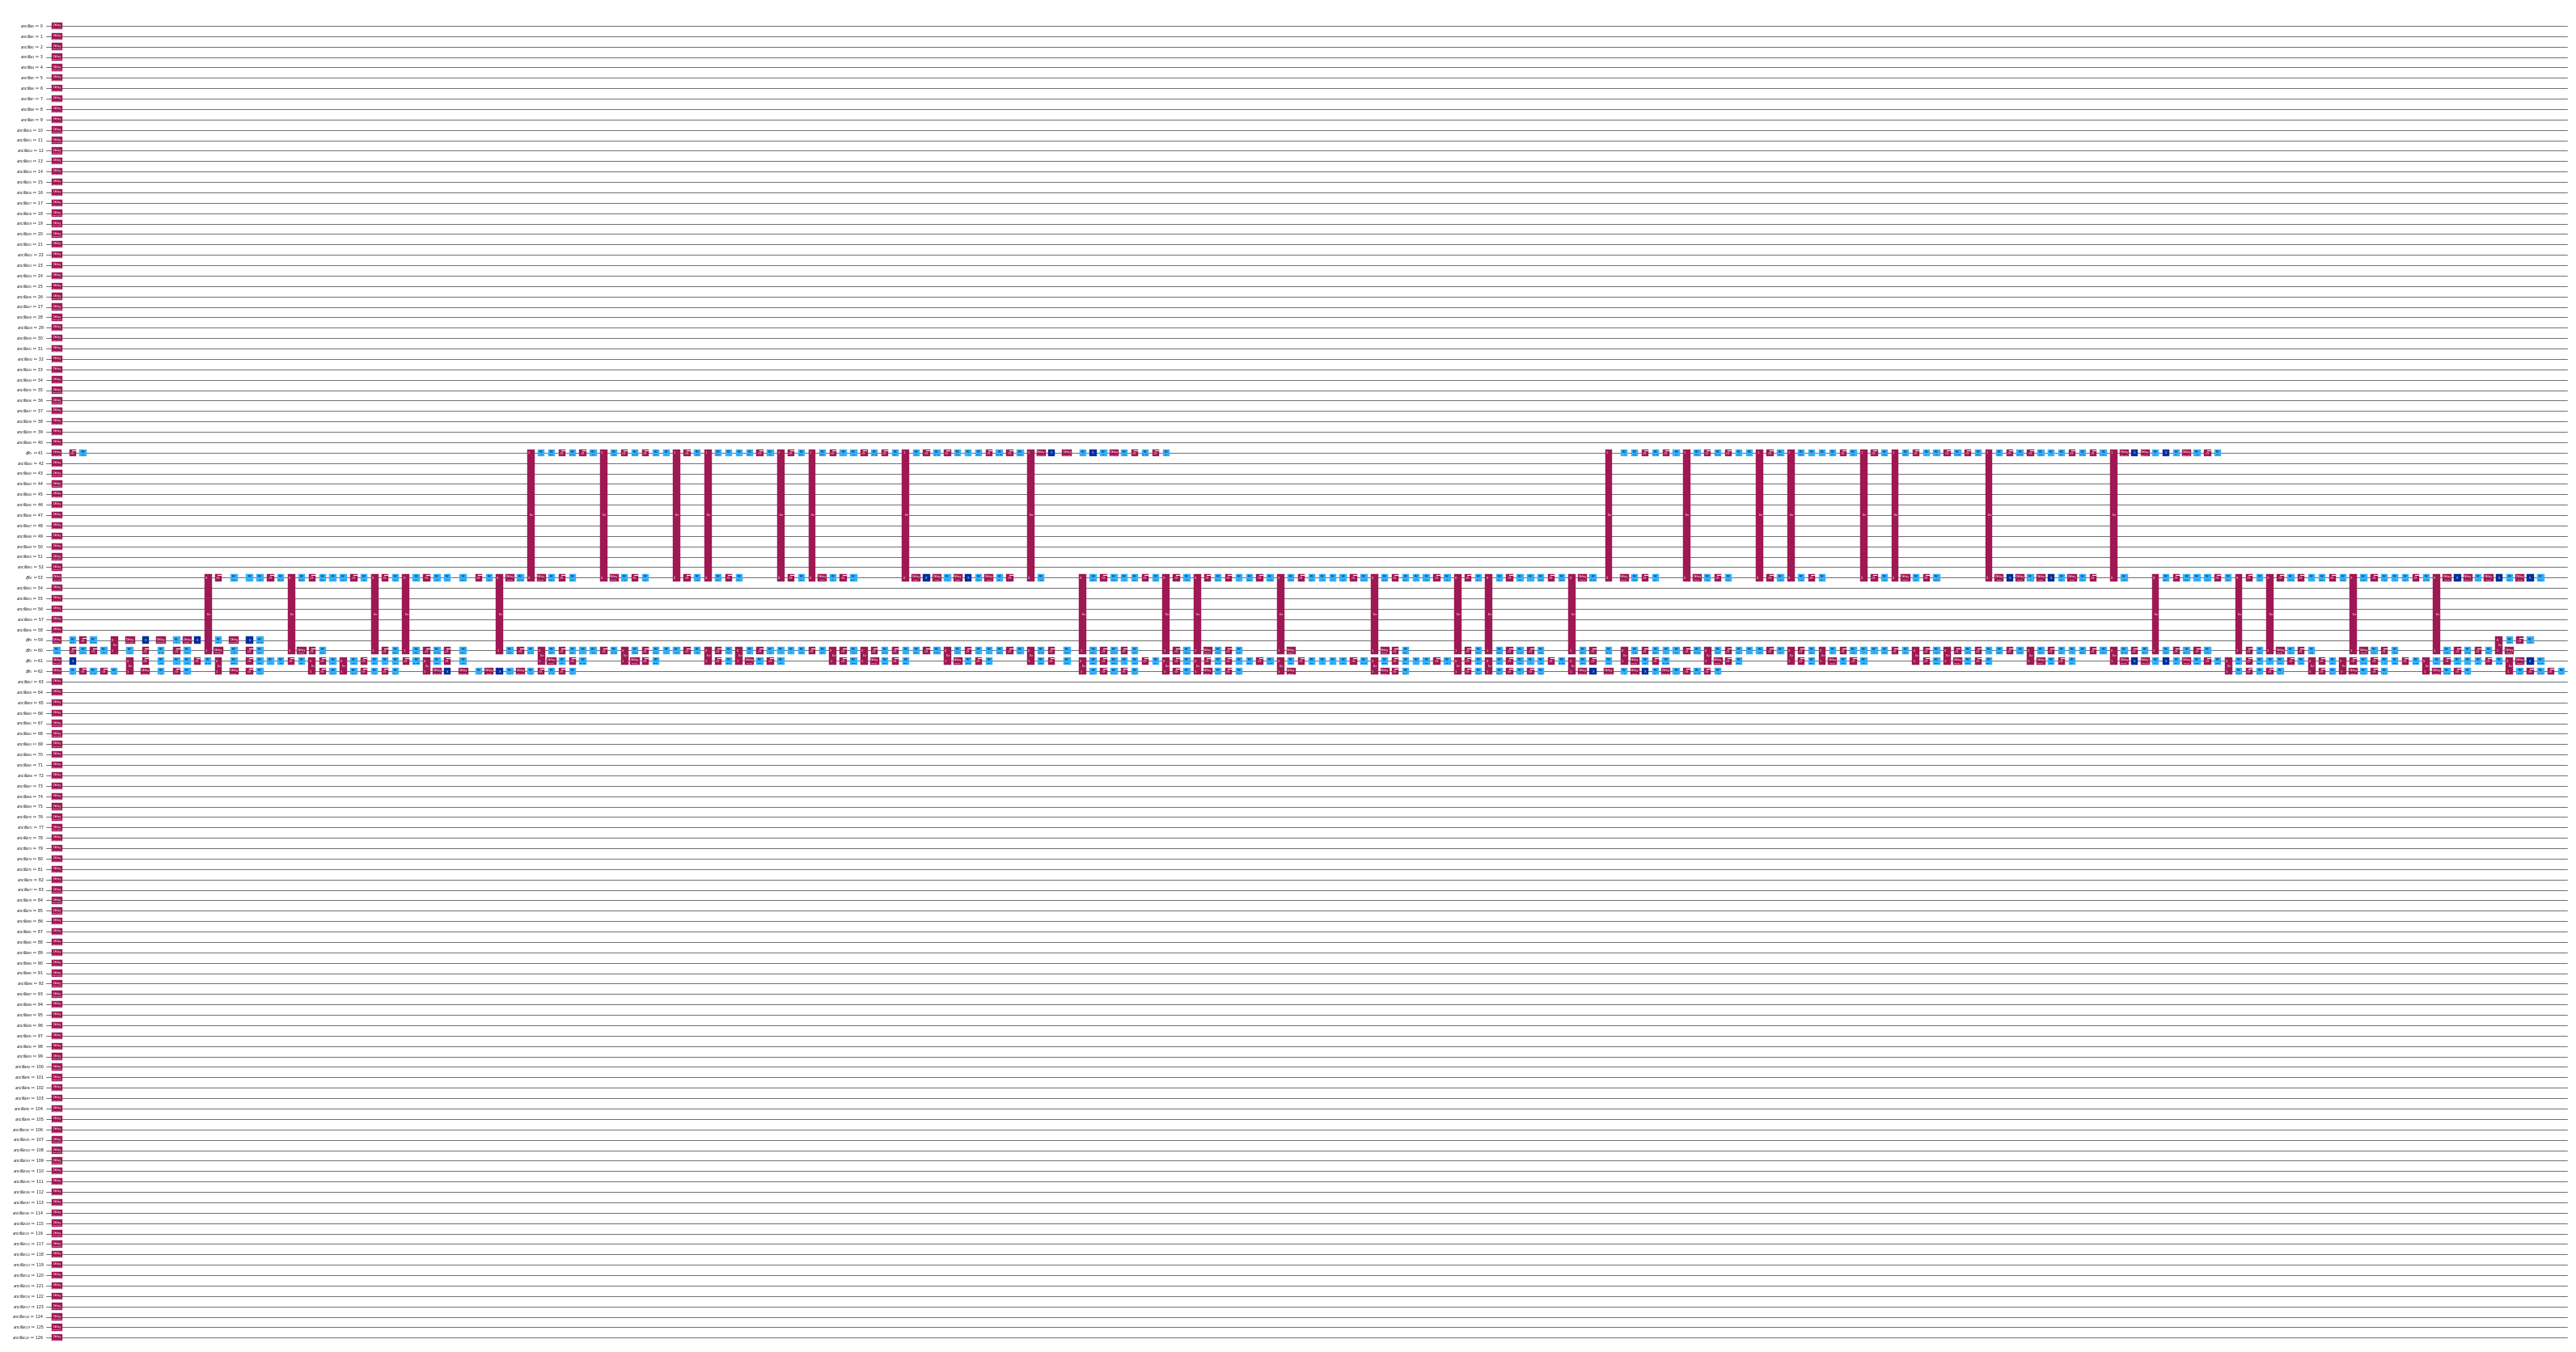

In [38]:
pub_S_real[0].draw('mpl', scale=0.2, fold=-1)

In [42]:
len(pub_S_real[1][0][0])

127

## PEA code

In [43]:
# Experiment options
max_pubs_per_batch_job = 100
num_randomizations = 7
num_randomizations_learning = 4
shots_per_randomization = 6
learning_pair_depths = [0, 1]
noise_factors = [1, 1.3, 1.6]

# Base option formatting
options = {
    "resilience_level": 2,
    # Builtin resilience settings for ZNE
    "resilience": {
        "measure_mitigation": True,
        "zne_mitigation": True,
        "zne": {"noise_factors": noise_factors},

        # TREX noise learning configuration
        "measure_noise_learning": {
            "num_randomizations": num_randomizations_learning,
            "shots_per_randomization": 3,
        },
        
        # PEA noise model configuration
        "layer_noise_learning": {
            "max_layers_to_learn": 5,
            "layer_pair_depths": learning_pair_depths,
            "shots_per_randomization": shots_per_randomization,
            "num_randomizations": num_randomizations_learning,
        },
    },
    
    # Randomization configuration
    "twirling": {
        "num_randomizations": num_randomizations,
        "shots_per_randomization": shots_per_randomization,
        "strategy": "active-circuit",
    },

    # Experimental settings for PEA method
    "experimental": {
        # Just in case, disable any further qiskit transpilation not related to twirling / DD
        "skip_transpilation": False,

        # Execution configuration
        "execution": {
            "max_pubs_per_batch_job": max_pubs_per_batch_job,
            "fast_parametric_update": True,
        },

        # Error Mitigation configuration
        "resilience": {
            # ZNE Configuration
            "zne": {
                "amplifier": "pea",
                "return_all_extrapolated": True,
                "return_unextrapolated": True,
                "extrapolated_noise_factors": noise_factors,
            }
        }
    }
}

In [44]:
from qiskit_ibm_runtime import EstimatorV2, Session

session = Session(backend=backend)
estimator = EstimatorV2(session=session, options= options)
job = estimator.run([pub_S_real])
session.close()

In [45]:
result = job.result()

RuntimeJobFailureError: 'Unable to retrieve job result. The `layer_qubits` does not span all LayerOp active qubits. -- Verify the input circuits and the traspilation options. -- https://ibm.biz/error_codes#1516'

In [ ]:
result

PrimitiveResult([PubResult(data=DataBin<1,210>(evs=[[ 0.61376953  0.57568359  0.59423828  0.54931641  0.60888672  0.63671875
   0.49707031  0.53417969  0.60595703  0.61083984  0.37597656  0.47558594
   0.55029297  0.58642578  0.62939453  0.28955078  0.37744141  0.47265625
   0.53515625  0.58496094  0.59765625  0.19970703  0.29589844  0.390625
   0.47705078  0.54589844  0.59521484  0.60791016  0.11474609  0.18359375
   0.27148438  0.37353516  0.45263672  0.55175781  0.59326172  0.61279297
   0.06103516  0.08544922  0.20849609  0.27685547  0.40087891  0.47314453
   0.53369141  0.59667969  0.62939453  0.00292969  0.06298828  0.09765625
   0.23632812  0.30859375  0.41357422  0.47070312  0.54394531  0.61523438
   0.63720703 -0.02001953  0.01171875  0.04101562  0.08886719  0.17675781
   0.27001953  0.39111328  0.47412109  0.52929688  0.58349609  0.625
   0.0078125  -0.01220703 -0.00585938  0.06201172  0.12109375  0.16796875
   0.28320312  0.36669922  0.47998047  0.57128906  0.58154297  0.618

In [33]:
with Session(backend=backend) as session:
    estimator = EstimatorV2(backend=backend,  options={"resilience_level": 2})

    # Sampling options
    estimator.options.seed_estimator = 1
    estimator.options.default_shots = 4
    estimator.options.twirling.num_randomizations = 2
    estimator.options.twirling.shots_per_randomization = 2
    estimator.options.resilience.layer_noise_learning.layer_pair_depths = [0, 4]
    estimator.options.resilience.layer_noise_learning.shots_per_randomization = 2
    estimator.options.resilience.layer_noise_learning.num_randomizations = 2


    # Additional options to enable and modify PEA based ZNE
    # estimator.options.resilience.zne.amplifier = "pea"
    estimator.options.resilience.zne.noise_factors = [1, 1.5, 2]

    # # Experimental options
    estimator.options.experimental.skip_transpilation = True
    estimator.options.experimental.fast_parametric_update = True

    


    job_S_real = estimator.run([pub_S_real])

In [34]:
job_S_real.result()#.metadata#['circuit_metadata']['physical_qubits']

RuntimeJobFailureError: 'Unable to retrieve job result. The `layer_qubits` does not span all LayerOp active qubits. -- Verify the input circuits and the traspilation options. -- https://ibm.biz/error_codes#1516'

In [115]:
from qiskit_ibm_runtime import EstimatorV2    
# from pec_runtime.primitives import EstimatorV2


if SIM and not NOISE:
    with Session(backend=backend) as session:
        estimator = EstimatorV2(session=session)
        job_S_real = estimator.run([pub_S_real], precision=1/np.sqrt(shots))
        job_S_imag = estimator.run([pub_S_imag], precision=1/np.sqrt(shots))
        job_H_real = estimator.run([pub_H_real], precision=1/np.sqrt(shots))
        job_H_imag = estimator.run([pub_H_imag], precision=1/np.sqrt(shots))
elif SIM and NOISE:
    with Session(backend=backend) as session:
        estimator = EstimatorV2(backend=backend,  options={"resilience_level": 2})

        # Sampling options
        estimator.options.seed_estimator = 1
        estimator.options.default_shots = 4
        estimator.options.twirling.num_randomizations = 2
        estimator.options.twirling.shots_per_randomization = 2
        estimator.options.resilience.layer_noise_learning.layer_pair_depths = [0, 4]
        estimator.options.resilience.layer_noise_learning.shots_per_randomization = 2
        estimator.options.resilience.layer_noise_learning.num_randomizations = 2
        estimator.options.execution.fast_parametric_update = True


        # Additional options to enable and modify PEA based ZNE
        # estimator.options.resilience.zne.amplifier = "pea"
        estimator.options.resilience.zne.noise_factors = [1, 1.5, 2]

        # # Experimental options
        estimator.options.experimental.skip_transpilation = True
        estimator.options.experimental.fast_parametric_update = True
        estimator.options.experimental.zne.amplifier = "pea"
        estimator.options.experimental.zne.return_all_extrapolated = True
        estimator.options.experimental.resilience.zne.return_unextrapolated = True
        estimator.options.experimental.resilience.zne.extrapolated_noise_factors = [1, 1.5, 2]
        


        job_S_real = estimator.run([pub_S_real])
        job_S_imag = estimator.run([pub_S_imag])
        job_H_real = estimator.run([pub_H_real])
        job_H_imag = estimator.run([pub_H_imag])

else:
    with Batch(backend=backend) as batch:

        estimator = EstimatorV2(session=batch, backend=backend, options={"resilience_level": 2})
        estimator.options.transpilation.seed_transpiler = 1

        # Sampling options
        estimator.options.seed_estimator = 1
        estimator.options.default_shots = 4
        estimator.options.twirling.num_randomizations = 2
        estimator.options.twirling.shots_per_randomization = 2
        estimator.options.resilience.layer_noise_learning.layer_pair_depths = [0, 4]
        estimator.options.resilience.layer_noise_learning.shots_per_randomization = 2
        estimator.options.resilience.layer_noise_learning.num_randomizations = 2
        estimator.options.execution.fast_parametric_update = True



        # Additional options to enable and modify PEA based ZNE
        # estimator.options.resilience.zne.amplifier = "pea"
        estimator.options.resilience.zne.noise_factors = [1, 1.5, 2]

        # # Experimental options
        # estimator.options.experimental.skip_transpilation = True
        # estimator.options.experimental.execution.fast_parametric_update = True
        # estimator.options.experimental.resilience.zne.amplifier = "pea"
        # estimator.options.experimental.resilience.zne.return_all_extrapolated = True
        # estimator.options.experimental.resilience.zne.return_unextrapolated = True
        # estimator.options.experimental.resilience.zne.extrapolated_noise_factors = [1, 1.5, 2]
        


        job_S_real = estimator.run([pub_S_real])
        job_S_imag = estimator.run([pub_S_imag])
        job_H_real = estimator.run([pub_H_real])
        job_H_imag = estimator.run([pub_H_imag])



ValidationError: 1 validation error for ExecutionOptionsV2
fast_parametric_update
  Object has no attribute 'fast_parametric_update' [type=no_such_attribute, input_value=True, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.6/v/no_such_attribute

## Without PEA

Execute circuits for $\tilde{S}$ and $\tilde{H}$ with the Estimator

In [39]:
if SIM:
    with Session(backend=backend) as session:
        estimator = Estimator(session=session)
        job_S_real = estimator.run([pub_S_real], precision=1/np.sqrt(shots))
        job_S_imag = estimator.run([pub_S_imag], precision=1/np.sqrt(shots))
        job_H_real = estimator.run([pub_H_real], precision=1/np.sqrt(shots))
        job_H_imag = estimator.run([pub_H_imag], precision=1/np.sqrt(shots))

else:
    with Batch(backend=backend):

        estimator = Estimator(options={"resilience_level": 1, "experimental": {"execution": {"fast_parametric_update" : True}}})

        job_S_real = estimator.run([pub_S_real], precision=1/np.sqrt(shots))
        job_S_imag = estimator.run([pub_S_imag], precision=1/np.sqrt(shots))
        job_H_real = estimator.run([pub_H_real], precision=1/np.sqrt(shots))
        job_H_imag = estimator.run([pub_H_imag], precision=1/np.sqrt(shots))


## Step 4: Post-process and analyze results

In [40]:
S_real_results = job_S_real.result()[0]
# S_imag_results = job_S_imag.result()[0]
# H_real_results = job_H_real.result()[0]
# H_imag_results = job_H_imag.result()[0]

In [41]:
job_S_real.result()#.metadata#['circuit_metadata']['physical_qubits']

PrimitiveResult([PubResult(data=DataBin<1,210>(evs=[[0.6426 0.62   0.6326 0.5932 0.6206 0.641  0.506  0.586  0.6258 0.6368
  0.4166 0.5052 0.5778 0.6166 0.635  0.3242 0.3956 0.513  0.5794 0.6106
  0.6408 0.2146 0.2916 0.4372 0.5026 0.5682 0.613  0.6406 0.1172 0.2056
  0.3022 0.408  0.514  0.5604 0.6096 0.6404 0.0698 0.1198 0.2078 0.309
  0.4086 0.5048 0.5646 0.6236 0.6374 0.0156 0.0664 0.1136 0.1968 0.3204
  0.3986 0.5182 0.5584 0.6078 0.6302 0.0218 0.0104 0.0614 0.1374 0.2206
  0.317  0.4066 0.4808 0.574  0.6128 0.6296 0.0124 0.0062 0.022  0.0534
  0.1082 0.2192 0.3036 0.3914 0.5056 0.5738 0.6068 0.6366 0.0402 0.0362
  0.0332 0.0148 0.06   0.134  0.2106 0.3214 0.391  0.5008 0.5646 0.6318
  0.63   0.0726 0.0304 0.0116 0.0072 0.0256 0.0566 0.1468 0.2368 0.2948
  0.4216 0.4938 0.5846 0.6378 0.6424 0.1064 0.0756 0.0256 0.0318 0.0078
  0.0248 0.067  0.149  0.2168 0.3    0.417  0.4906 0.5804 0.6182 0.6506
  0.1272 0.104  0.079  0.0316 0.0318 0.0142 0.014  0.071  0.1512 0.2178
  0.3108 0.395

In [38]:
job_S_real.result()#.metadata#['circuit_metadata']['physical_qubits']

PrimitiveResult([PubResult(data=DataBin<1,210>(evs=[[ 0.6334  0.6132  0.629   0.578   0.6296  0.6392  0.5062  0.5662  0.6098
   0.6368  0.4124  0.4924  0.566   0.6232  0.6258  0.3242  0.3982  0.491
   0.5768  0.624   0.6404  0.218   0.3082  0.4014  0.5038  0.5764  0.6232
   0.631   0.1274  0.2198  0.2974  0.4038  0.506   0.5674  0.632   0.6406
   0.066   0.1128  0.208   0.315   0.4024  0.5022  0.5678  0.6194  0.6538
   0.021   0.0698  0.1332  0.2066  0.3166  0.4108  0.4944  0.5746  0.6178
   0.6478  0.0148  0.0228  0.057   0.1342  0.2096  0.3018  0.3918  0.494
   0.5614  0.6074  0.6366  0.0074  0.0208  0.0292  0.0646  0.1242  0.2166
   0.3156  0.4182  0.5006  0.5782  0.6074  0.6218  0.029   0.0136  0.0124
   0.03    0.0606  0.1332  0.2158  0.3128  0.4042  0.509   0.5704  0.6336
   0.637   0.0748  0.0468  0.0124  0.022   0.0182  0.0564  0.1356  0.2096
   0.316   0.4188  0.4862  0.5712  0.6314  0.6368  0.1076  0.0784  0.0392
   0.017   0.0108  0.0274  0.0542  0.1338  0.2062  0.3052  0.41

Once we have the results of the circuit executions we can post-process the data to calculate the matrix elements of $\tilde{S}$

In [22]:
S_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)
count = 0
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):

        # Get expectation values from experiment
        expval_real = S_real_results.data.evs[0][count]
        expval_imag = S_imag_results.data.evs[0][count]

        # Get expectation values
        expval = expval_real + 1j*expval_imag

        # Fill-in matrix elements
        S_circ[idx_bra, idx_ket] = expval
        S_circ[idx_ket, idx_bra] = expval.conjugate()

        count+=1

And the matrix elements of $\tilde{H}$

In [23]:
H_eff_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)
for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    count = 0
    for idx_ket in range(krylov_dim):
        for idx_bra in range(idx_ket + 1):
            # Get expectation values from experiment
            expval_real = H_real_results.data.evs[obs_idx][count]
            expval_imag = H_imag_results.data.evs[obs_idx][count]
            

            # # Get expectation values
            expval = expval_real + 1j*expval_imag


            # Fill-in matrix elements
            H_eff_circ[idx_bra, idx_ket] += coeff*expval
            if idx_bra != idx_ket: # don't duplicate terms on diagonal
                H_eff_circ[idx_ket, idx_bra] += (coeff*expval).conjugate()


            count+=1

Finally, we can solve the generalized eigenvalue problem for $\tilde{H}$:

$$\tilde{H} \vec{c} = c \tilde{S} \vec{c}$$

and get an estimate of the ground state energy $c_{min}$

In [24]:
gnd_en_circ_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ[:d, :d], S_circ[:d, :d], threshold=1e-2)
    gnd_en_circ_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  0.26780626780626776
The estimated ground state energy is:  0.2571596326360334
The estimated ground state energy is:  -2.088423567723849
The estimated ground state energy is:  -2.1150162441636375
The estimated ground state energy is:  -1.5768447426726748
The estimated ground state energy is:  -3.683377378038289
The estimated ground state energy is:  -2.078228250410395
The estimated ground state energy is:  -2.24786630746533
The estimated ground state energy is:  -2.0216943674658805
The estimated ground state energy is:  -2.179324467508608
The estimated ground state energy is:  -2.1144242577275505
The estimated ground state energy is:  -2.3288787833167985
The estimated ground state energy is:  -2.2317909976139845
The estimated ground state energy is:  -2.4191922416943368
The estimated ground state energy is:  -3.413101189246737
The estimated ground state energy is:  -3.5056946836307
The estimated ground state energy is:  -5.322213864342202
The estim

In [25]:
from sympy import Matrix
Matrix(S_circ)

Matrix([
[0.6318 - 0.0396*I,  0.6288 + 0.1286*I,  0.573 + 0.2246*I,    0.495 + 0.32*I, 0.4098 + 0.3476*I, 0.3166 + 0.4018*I,   0.2138 + 0.373*I,    0.1482 + 0.35*I, 0.0716 + 0.2968*I,   0.029 + 0.2372*I, 0.0132 + 0.1908*I,   0.007 + 0.1426*I, 0.0356 + 0.0588*I, 0.0766 + 0.0426*I, 0.1288 + 0.0334*I, 0.1356 + 0.0562*I,   0.141 + 0.0866*I, 0.1628 + 0.0982*I, 0.1536 + 0.1506*I,    0.13 + 0.1836*I],
[0.6288 - 0.1286*I,  0.6306 - 0.0284*I, 0.6286 + 0.1378*I, 0.5828 + 0.2354*I,  0.5034 + 0.321*I,  0.4004 + 0.363*I,  0.3012 + 0.3802*I,  0.2254 + 0.3962*I, 0.1476 + 0.3382*I,  0.0734 + 0.3074*I,   0.014 + 0.238*I, -0.0018 + 0.1556*I, 0.0248 + 0.1038*I, 0.0466 + 0.0624*I, 0.0716 + 0.0382*I,  0.116 + 0.0588*I,    0.155 + 0.043*I,  0.1506 + 0.077*I, 0.1686 + 0.1114*I,  0.1398 + 0.1388*I],
[ 0.573 - 0.2246*I,  0.6286 - 0.1378*I, 0.6304 - 0.0254*I,  0.635 + 0.1294*I, 0.5842 + 0.2468*I,   0.507 + 0.304*I,  0.4216 + 0.3662*I,  0.3154 + 0.3948*I, 0.2086 + 0.3828*I,  0.1428 + 0.3572*I,  0.0678 + 0.295*I,

In [26]:
from qiskit.quantum_info import Pauli
import time
import itertools as it

H_x = []
for p, coeff in H_op.to_list():
    H_x.append(set([i for i,v in enumerate(Pauli(p).x) if v]))

H_z = []
for p, coeff in H_op.to_list():
    H_z.append(set([i for i,v in enumerate(Pauli(p).z) if v]))

H_c = H_op.coeffs

print('n_sys_qubits', n_qubits)

# n_exc particle Hamiltonian:

n_exc = 1
sub_dimn = int(sp.special.comb(n_qubits+1,n_exc))
print('n_exc', n_exc, ', subspace dimension', sub_dimn)

few_particle_H = np.zeros((sub_dimn,sub_dimn), dtype=complex)

sparse_vecs = [set(vec) for vec in it.combinations(range(n_qubits+1),r=n_exc)] # list all of the possible sets of n_exc indices of 1s in n_exc-particle states

start_time = time.time()
m = 0
for i, i_set in enumerate(sparse_vecs):
    for j, j_set in enumerate(sparse_vecs):
        m += 1
        # if m % int((sub_dimn**2)/100) == 0:
        #     print(np.round(m/int((sub_dimn**2)/100),2), '% complete, time =', time.time()-start_time)
        #     start_time = time.time()

        if len(i_set.symmetric_difference(j_set)) <= 2:

            for p_x, p_z, coeff in zip(H_x, H_z, H_c):

                if i_set.symmetric_difference(j_set) == p_x:
                    sgn = ((-1j)**len(p_x.intersection(p_z)))*((-1)**len(i_set.intersection(p_z)))
                else:
                    sgn = 0

                few_particle_H[i,j] += sgn*coeff

gs_en = min(np.linalg.eigvalsh(few_particle_H))
print('gs_en', gs_en)




n_sys_qubits 5
n_exc 1 , subspace dimension 6
gs_en -3.23606797749979


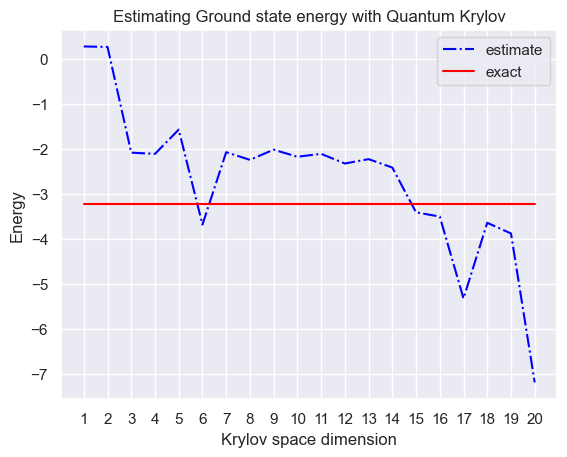

In [27]:
plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list, color = 'blue', linestyle='-.' , label = 'estimate')
plt.plot(range(1, krylov_dim+1), [gs_en]*krylov_dim, color = 'red', linestyle='-' , label = 'exact')
plt.xticks(range(1, krylov_dim+1), range(1, krylov_dim+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')
plt.show()